<a href="https://colab.research.google.com/github/Igor-ID/g.tec-Hackathon-Unresponsive-Wakefullness-Syndrom-Data-Analysis/blob/main/gtec_hackathon_uws_p300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
%matplotlib inline
!pip install mne
!pip install pyriemann
import mne
import matplotlib.pyplot as plt
import scipy
import os
from scipy.io import loadmat
import numpy as np
import mne
import pandas as pd
from mne.decoding import Vectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from collections import OrderedDict
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from google.colab import drive
drive.mount('/content/drive')



     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=2a2cb97d030c6a52a50ba1fe0d9c8adb3a6f2b53c1d77608ae064104b7854717
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Helper func to create epochs object

In [66]:
# file_name = "/content/drive/My Drive/data/P2_high1.mat"
# # file_name2 = "data/P1_high2.mat"
# data = loadmat(file_name)
# # data2 = loadmat(file_name2)
# eeg_data = data['y']
# eeg_data.shape
# helper func to create epoch object
def create_epochs(starting_dir="/content/drive/My Drive/data/", item='P1_high1.mat'):
    eeg_ch = ['Fz', 'C3', 'Cz', 'C4', 'CP1', 'CPz', 'CP2', 'Pz']
    fs = 256
    n_channels = 8
    event_id = dict(distractor=-1, rest=0, nontarget=1, target=2)
    info = mne.create_info(ch_names=eeg_ch, sfreq=fs, ch_types='eeg')
    info.set_montage('standard_1020')
    file_name = os.path.join(starting_dir, item)
    data = loadmat(file_name)
    eeg_data = data['y']
    eeg_data = eeg_data * 1e-6

    raw = mne.io.RawArray(eeg_data.T, info)
    stim_data = data['trig']
    stim_data[stim_data == -1] = 3  # change stimulus negative value of -1 to 3 for correct stimulus reading by mne
    info_event = mne.create_info(['STI'], sfreq=fs, ch_types='stim')
    stim_raw = mne.io.RawArray(stim_data.T, info_event)
    raw.add_channels([stim_raw], force_update_info=True)

    events = mne.find_events(raw, stim_channel='STI')

    raw.notch_filter(freqs=50)  # creating band-stop filter to eliminate power line noise (US - 60Hz, EU - 50Hz)
    raw.filter(l_freq=0.1, h_freq=30)  # creating band-pass filter, to eliminate non-physiological frequencies

    epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=0.6, reject={'eeg': 100e-6}, preload=True)
    return epochs

In [78]:
epochs_train = create_epochs()
epochs_train.pick_types(eeg=True)
# event_ids = {'distractor': 3, 'rest': 0, 'nontarget': 1, 'target': 2}
X = epochs_train.get_data()  # features
y = epochs_train.events[:, -1]  # labels
X, y

Creating RawArray with float64 data, n_channels=8, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=38976
    Range : 0 ... 38975 =      0.000 ...   152.246 secs
Ready.
480 events found
Event IDs: [1 2 3]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpas

(array([[[-1.73926353e-05, -1.91928221e-05, -2.14450772e-05, ...,
           5.34220556e-06, -2.56244221e-07, -4.81489551e-06],
         [-1.03376614e-05, -1.20804882e-05, -1.41910149e-05, ...,
           3.83773912e-06,  4.08800201e-07, -2.72862412e-06],
         [-1.50375802e-05, -1.68690122e-05, -1.87448544e-05, ...,
           1.01016948e-05,  4.72040590e-06, -1.41307361e-07],
         ...,
         [-1.26141264e-05, -1.45919774e-05, -1.63169868e-05, ...,
           4.52273181e-06, -1.19877254e-06, -6.40834764e-06],
         [-1.14450576e-05, -1.32930601e-05, -1.52907066e-05, ...,
           1.60760751e-05,  1.01746171e-05,  4.31416866e-06],
         [-8.68670464e-06, -1.08900082e-05, -1.29845991e-05, ...,
           1.05879163e-05,  4.85713451e-06, -7.83720318e-07]],
 
        [[-2.36912552e-05, -2.59533072e-05, -2.84222838e-05, ...,
           2.34055872e-05,  2.53967832e-05,  2.84844407e-05],
         [-7.26549756e-06, -9.73585104e-06, -1.15535804e-05, ...,
           2.18698838

Opening epochs-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


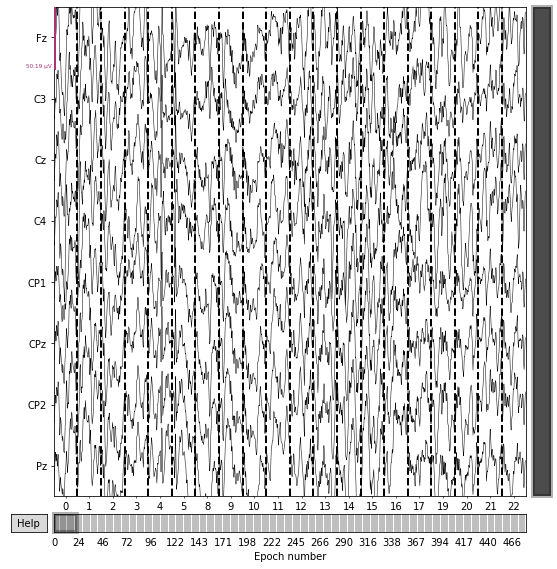

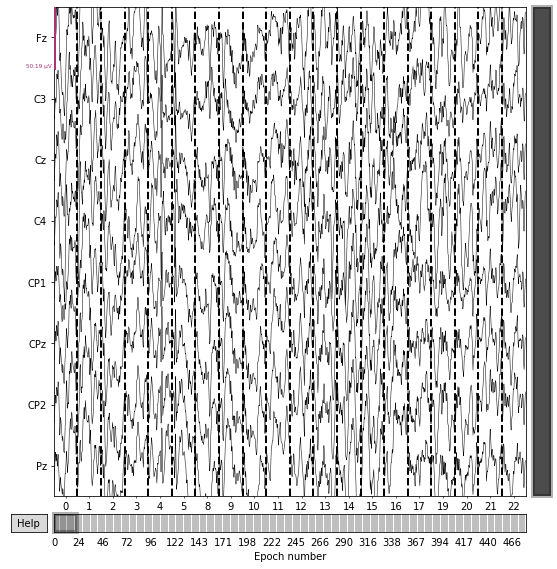

In [72]:
epochs_train.plot(scalings='auto')

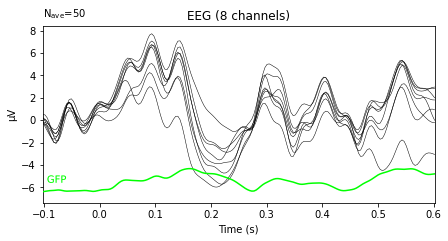

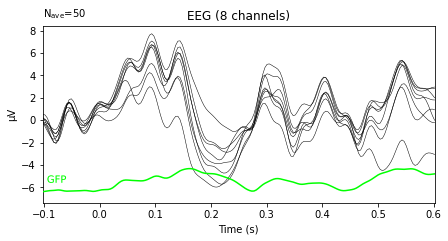

In [73]:
evoked = epochs_train['1'].average()
evoked.plot(gfp=True)

combining channels using "gfp"
combining channels using "gfp"


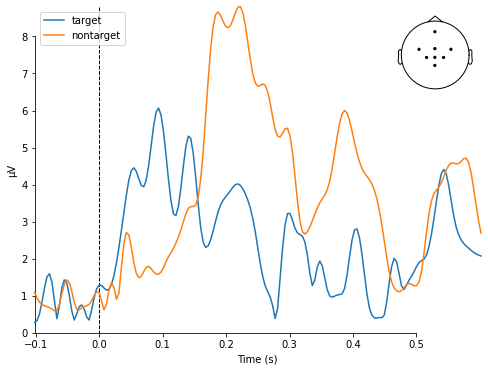

[<Figure size 576x432 with 2 Axes>]

In [81]:
evoked_nontarget = epochs_train['2'].average()

mne.viz.plot_compare_evokeds(dict(target=evoked, nontarget=evoked_nontarget),
                             legend='upper left', show_sensors='upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


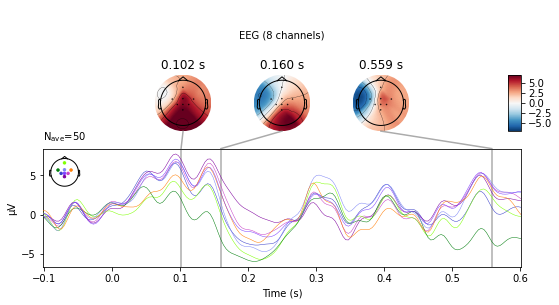

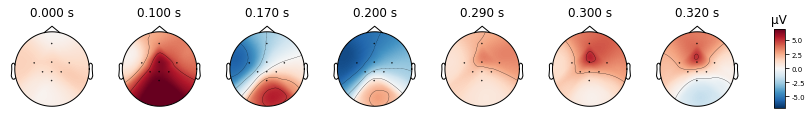

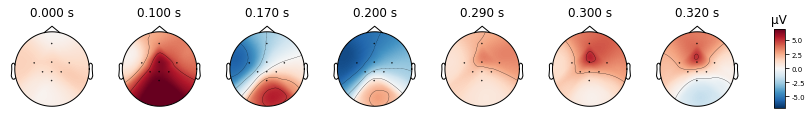

In [74]:
evoked.plot_joint(picks='eeg')
evoked.plot_topomap(times=[0., 0.1, 0.17, 0.2, 0.29, 0.3, 0.32], ch_type='eeg')

In [75]:
X_average = evoked.get_data()  # features
# y = evoked.events[:, -1]  # labels
X_average.shape

(8, 181)

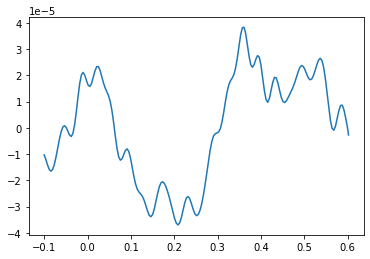

In [76]:
time = np.arange(-0.1, 0.6, 1/256)
t = np.append(time, 0.602)
t.shape
plt.plot(t, X[0][1])
# X.shape, X[0].shape, X[0][0].shape

In [85]:

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
# epochs.pick_types(eeg=True)
# X = epochs.get_data() * 1e6
# times = epochs.times
# y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y=='1', scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        print(res)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


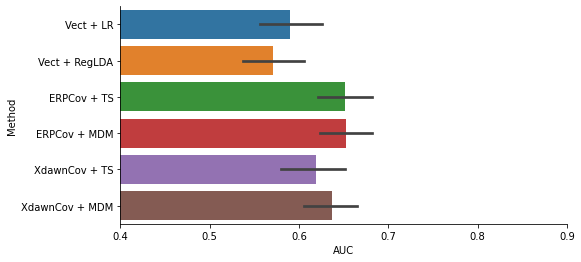

In [80]:
## Plot Decoding Results
import seaborn as sns
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()

In [ ]:
# shape
X.shape, y.shape

((480, 8, 181), (480,))

In [ ]:
epochs_test = create_epochs(item='P1_high2.mat')
epochs_test.pick_types(eeg=True)
X_test = epochs_test.get_data()  # features
y_test = epochs_test.events[:, -1]  # labels
X_test.shape, y_test.shape

Creating RawArray with float64 data, n_channels=8, n_times=39000
    Range : 0 ... 38999 =      0.000 ...   152.340 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=39000
    Range : 0 ... 38999 =      0.000 ...   152.340 secs
Ready.
480 events found
Event IDs: [1 2 3]
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpas

((480, 9, 181), (480,))

X has the wrong shape - `samples`, `channels`, `times`, should be `samples`, `features`.

We can use `mne.decoding.Vectorizer` to correctly shape the data. It fits right into a scikit-learn pipeline.

In [ ]:
clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis())
clf

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7f587e1177d0>),
                ('standardscaler', StandardScaler()),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

The resulting object behaves exactly as any other scikit-learn classifier:

In [ ]:
clf.fit(X, y)

Pipeline(steps=[('vectorizer',
                 <mne.decoding.transformer.Vectorizer object at 0x7f587e1177d0>),
                ('standardscaler', StandardScaler()),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [ ]:
y_test[:9]

array([3, 3, 3, 1, 3, 3, 3, 2, 1])

In [ ]:
# we have slightly different shape of the initial data, improvements required
clf.predict(X_test[:9])

ValueError: ignored

Of course, usually we care about cross-validated scores.

In [ ]:
cross_val_score(clf, X, y, cv=10)  # accuracy

array([0.625     , 0.33333333, 0.375     , 0.39583333, 0.25      ,
       0.45833333, 0.66666667, 0.33333333, 0.27083333, 0.47916667])

Also we can get pandas dataframe and try to work with dataframe

In [ ]:
df = epochs_train.to_data_frame()
df

,time,condition,epoch,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz
0,-102,2,0,-1.739264e+07,-1.033766e+07,-1.503758e+07,-1.238139e+07,-9.334798e+06,-1.261413e+07,-1.144506e+07,-8.686705e+06
1,-98,2,0,-1.919282e+07,-1.208049e+07,-1.686901e+07,-1.445377e+07,-1.187503e+07,-1.459198e+07,-1.329306e+07,-1.089001e+07
2,-94,2,0,-2.144508e+07,-1.419101e+07,-1.874485e+07,-1.718714e+07,-1.419023e+07,-1.631699e+07,-1.529071e+07,-1.298460e+07
3,-90,2,0,-2.304324e+07,-1.587842e+07,-1.961164e+07,-1.927582e+07,-1.528547e+07,-1.676155e+07,-1.628773e+07,-1.393093e+07
4,-86,2,0,-2.324476e+07,-1.653688e+07,-1.884115e+07,-1.976673e+07,-1.465692e+07,-1.540207e+07,-1.557934e+07,-1.313645e+07
...,...,...,...,...,...,...,...,...,...,...,...
86875,586,3,479,3.719924e+07,4.041718e+07,3.345031e+07,3.085907e+07,3.648423e+07,3.382565e+07,2.915689e+07,2.858775e+07
86876,590,3,479,4.021684e+07,4.036070e+07,3.559597e+07,3.548898e+07,3.635516e+07,3.464480e+07,3.101162e+07,2.906428e+07
86877,594,3,479,4.328137e+07,4.070453e+07,3.731369e+07,4.016472e+07,3.630488e+07,3.533924e+07,3.277748e+07,2.970342e+07
86878,598,3,479,4.617468e+07,4.186785e+07,3.878067e+07,4.470226e+07,3.703376e+07,3.646899e+07,3.485472e+07,3.112316e+07


We can make some grouping

In [ ]:
df_group = df.astype(str).groupby(['epoch', 'condition'], sort=False).agg(lambda x: ','.join(x.unique())).reset_index()
df_group

,epoch,condition,time,Fz,C3,Cz,C4,CP1,CPz,CP2,Pz
0,0,2,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-17392635.34031483,-19192822.09249928,-2144507...","-10337661.356537865,-12080488.177490069,-14191...","-15037580.169168018,-16869012.20588905,-187448...","-12381387.280760095,-14453772.6205328,-1718714...","-9334798.22835815,-11875027.560281485,-1419022...","-12614126.419395909,-14591977.415441647,-16316...","-11445057.641401213,-13293060.1079042,-1529070...","-8686704.64218776,-10890008.21057207,-12984599..."
1,1,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-23691255.239405777,-25953307.245922253,-28422...","-7265497.56256604,-9735851.041420681,-11553580...","-25879456.665909786,-26751246.46794074,-273989...","-36185167.242535576,-37223156.513045736,-39234...","-13131907.960676994,-14103812.42879546,-146154...","-22229875.72986667,-23047200.773827825,-234695...","-27355153.451211706,-27522592.401410934,-28043...","-20320066.74937186,-20190147.522180185,-199328..."
2,2,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","3687239.867484742,3344686.2353325263,2579012.4...","9695126.533514278,8443765.267391525,6777832.12...","5601364.612770441,4995163.275359974,4540030.77...","392843.30679542554,-207659.48057504246,-150936...","8901028.253594035,8750799.683899647,8802077.42...","7449573.982954376,7176527.331653045,6793884.52...","5007284.317872293,3938523.1555216354,2809830.9...","5996596.405416256,5727139.1389800655,5210678.3..."
3,3,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-6945962.405065572,-7030749.930879232,-6489556...","-18124095.088715103,-17620614.469125483,-15697...","-11506104.55012702,-10075618.049375052,-798248...","-1288504.427487549,-950143.2056839167,52583.78...","-17025379.030884195,-15890571.830845617,-13688...","-11024461.793595755,-9905895.915042678,-815222...","-6656476.94173872,-6306044.032280414,-5331021....","-12659886.662596963,-11152331.692799823,-89852..."
4,4,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-6424609.164251912,-5976640.150712482,-5226813...","-1402011.3326451282,-2175049.443315369,-274349...","-11754468.582489617,-12448139.829915041,-12458...","-17784511.13235444,-17537108.513425317,-167686...","-11894627.509218529,-12411136.27068467,-125160...","-12738240.472459894,-12510975.243798498,-12051...","-16945114.268358685,-16640974.13887149,-156498...","-12849043.924038783,-13019843.085149523,-12800..."
...,...,...,...,...,...,...,...,...,...,...,...
475,475,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","2895803.097475225,4664418.56996655,5945687.304...","3491047.6999797877,3761243.0473592295,4011554....","4813659.803877002,5211779.416930686,4992879.61...","288538.9373760976,1596378.0230810123,1686438.8...","3788519.484260227,3395298.3516255324,2959167.4...","940083.1781267285,1233105.6182623014,1247679.1...","3772913.8301097187,3486646.7217355357,2637938....","245719.00456015716,-219054.4831675172,-690811...."
476,476,1,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-14244806.843571873,-12413038.004151007,-94214...","-16611586.00969057,-14809543.326976353,-112468...","-16180059.573299605,-12792713.902872493,-82265...","-18479361.6206336,-16163182.59962339,-12979084...","-15676286.24327426,-13245292.760042027,-957977...","-14104242.05127295,-11434409.077598834,-762398...","-16026874.338660832,-13217148.075958794,-90328...","-12243335.379122125,-10259991.980605451,-69459..."
477,477,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","41235536.57056885,40823410.773975536,36862483....","28830861.740704913,29925331.018826853,27066033...","35562402.75477381,35339562.84160082,31101489.8...","26934785.351500288,26938845.778887324,23592767...","22464993.64492451,22964622.098963767,19959997....","27002441.41715529,27198026.28921295,23403167.1...","26374603.673385125,26258277.38198,22263204.801...","20957196.954102103,20402695.37241129,16493276...."
478,478,3,"-102,-98,-94,-90,-86,-82,-78,-74,-70,-66,-62,-...","-12744044.414028239,-12522110.717205

Or we can have dataframe directly from mne epochs object

In [ ]:
df_mne = epochs_train.to_data_frame(index=['condition', 'epoch'])
df_mne

time            Fz            C3            Cz            C4  \
condition epoch                                                                 
2         0      -102 -1.739264e+07 -1.033766e+07 -1.503758e+07 -1.238139e+07   
          0       -98 -1.919282e+07 -1.208049e+07 -1.686901e+07 -1.445377e+07   
          0       -94 -2.144508e+07 -1.419101e+07 -1.874485e+07 -1.718714e+07   
          0       -90 -2.304324e+07 -1.587842e+07 -1.961164e+07 -1.927582e+07   
          0       -86 -2.324476e+07 -1.653688e+07 -1.884115e+07 -1.976673e+07   
...               ...           ...           ...           ...           ...   
3         479     586  3.719924e+07  4.041718e+07  3.345031e+07  3.085907e+07   
          479     590  4.021684e+07  4.036070e+07  3.559597e+07  3.548898e+07   
          479     594  4.328137e+07  4.070453e+07  3.731369e+07  4.016472e+07   
          479     598  4.617468e+07  4.186785e+07  3.878067e+07  4.470226e+07   
          479     602  4.881327e+07  4.406456e+07  4.039625e+07  4.909884e+07   

                          CP1           CPz           CP2            Pz  
condition epoch                                                          
2         0     -9.334798e+06 -1.261413e+07 -1.144506e+07 -8.686705e+06  
          0     -1.187503e+07 -1.459198e+07 -1.329306e+07 -1.089001e+07  
          0     -1.419023e+07 -1.631699e+07 -1.529071e+07 -1.298460e+07  
          0     -1.528547e+07 -1.676155e+07 -1.628773e+07 -1.393093e+07  
          0     -1.465692e+07 -1.540207e+07 -1.557934e+07 -1.313645e+07  
...                       ...           ...           ...           ...  
3         479    3.648423e+07  3.382565e+07  2.915689e+07  2.858775e+07  
          479    3.635516e+07  3.464480e+07  3.101162e+07  2.906428e+07  
          479    3.630488e+07  3.533924e+07  3.277748e+07  2.970342e+07  
          479    3.703376e+07  3.646899e+07  3.485472e+07  3.112316e+07  
          479    3.911887e+07  3.859761e+07  3.772299e+07  3.387690e+07  

[86880 rows x 9 columns]